In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
# from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
# from tensorflow.keras.models import Model
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# import tqdm

1. Load Munch Data

<AxesSubplot:>

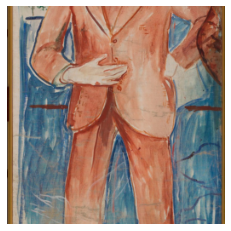

In [5]:
painting_details_munch =  pd.read_csv('./datasets/munch_paintings/edvard_munch.csv')
# painting_details.head()
image_path_munch = './datasets/munch_paintings/munch_paintings'
# here after viewing real size for images we can say 256*256 would be good.
# image_size = (256,256)
# separate data into training, validation and testing
test_split = .2
val_split = .1
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and testing splits:
data_size = len(painting_details_munch)
indices = list(range(data_size))
split = int(np.floor(test_split * data_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
# Creating data indices for training and validation splits:
train_size = len(train_indices)
indices = list(range(train_size))
split = int(np.floor(val_split * train_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


batch_size = 32
# ImageFolder expects the class folder
images_dataset_munch = torchvision.datasets.ImageFolder(image_path_munch,\
                                                  transform=transforms.Compose([transforms.Resize(256), 
                                                    #smaller edge of the image will be matched to this number.
                                 transforms.CenterCrop(256),
                                 transforms.ToTensor()]))
# data_loader_munch = DataLoader(images_dataset_munch, batch_size=batch_size,shuffle=False)
# wrapup into dataloader
train_loader = DataLoader(images_dataset_munch, batch_size=batch_size,sampler=train_sampler)
valid_loader = DataLoader(images_dataset_munch, batch_size=batch_size,sampler=valid_sampler)
test_loader = DataLoader(images_dataset_munch, batch_size=batch_size,shuffle=False)

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0)) # (3,256,256) -> (256,256,3)

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1) #Given an interval, values outside the interval are clipped to the interval edges.

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

images, labels = next(iter(train_loader))
imshow(images[10], normalize=False)

2.1 Basic Autoencoders using feedfoward nn -- model setup and train

In [27]:
# latent_dim = 300

class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # self.latent_dim = latent_dim
        # encoder (1 layer)
        self.encoder = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(in_features=kwargs["input_shape"],out_features=kwargs["latent_shape"]),
            nn.ReLU(),
            nn.Linear(in_features=kwargs["latent_shape"],out_features=kwargs["latent_shape"]),
            nn.ReLU())
        # decoder (1 layer)
        self.decoder = nn.Sequential(
            nn.Linear(in_features=kwargs["latent_shape"],out_features=kwargs["latent_shape"]),
            nn.ReLU(),
            nn.Linear(in_features=kwargs["latent_shape"],out_features=kwargs["input_shape"]),
            nn.Sigmoid())
            # torch.reshape((28,28)))

    def forward(self, input_features):
        encoded = self.encoder(input_features)
        decoded = self.decoder(encoded)
        return decoded
    
# load model to the specified device, either gpu or cpu
autoencoder = Autoencoder(input_shape=3*256*256,latent_shape=300).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train model
def train_AE(num_epochs,model,optimizer,criterion,train_loader,valid_loader):
    # for epoch in tqdm(range(epochs)):
    for epoch in range(num_epochs):
        loss_tr = 0
        loss_val = 0
        # training loop
        for batch_features, _ in train_loader:
            # load it to active device
            batch_features = batch_features.view(-1, 3*256*256).to(device)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            # compute reconstructions
            outputs = model(batch_features)
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            # compute accumulated gradients
            train_loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # add the mini-batch training loss to epoch loss
            loss_tr += train_loss.item()
        # compute the epoch training loss
        loss_tr = loss_tr / len(train_loader)

        # valid loop
        with torch.no_grad():
            model.eval()
            for batch_features, _ in valid_loader: 
                batch_features = batch_features.view(-1, 3*256*256).to(device)
                reconstructed = model(batch_features)
                valid_loss = criterion(reconstructed, batch_features)
                loss_val += valid_loss.item()
            loss_val = loss_val / len(train_loader)

        # display the epoch loss
        print("epoch : {}/{},  traing loss = {:.6f}, valid loss = {:.6f}".format(epoch + 1, num_epochs, loss_tr, loss_val))

train_AE(num_epochs=20,model=autoencoder,optimizer=optimizer,criterion=criterion,train_loader=train_loader, valid_loader=valid_loader)

epoch : 1/20,  traing loss = 0.059837, valid loss = 0.006190
epoch : 2/20,  traing loss = 0.049664, valid loss = 0.005820
epoch : 3/20,  traing loss = 0.047752, valid loss = 0.005596
epoch : 4/20,  traing loss = 0.047392, valid loss = 0.005703
epoch : 5/20,  traing loss = 0.046923, valid loss = 0.005597
epoch : 6/20,  traing loss = 0.046853, valid loss = 0.005672
epoch : 7/20,  traing loss = 0.047107, valid loss = 0.005614
epoch : 8/20,  traing loss = 0.046612, valid loss = 0.005541
epoch : 9/20,  traing loss = 0.046551, valid loss = 0.005544
epoch : 10/20,  traing loss = 0.046626, valid loss = 0.005599
epoch : 11/20,  traing loss = 0.046530, valid loss = 0.005534
epoch : 12/20,  traing loss = 0.046502, valid loss = 0.005578
epoch : 13/20,  traing loss = 0.046178, valid loss = 0.005638
epoch : 14/20,  traing loss = 0.046135, valid loss = 0.005497
epoch : 15/20,  traing loss = 0.046439, valid loss = 0.005582
epoch : 16/20,  traing loss = 0.046074, valid loss = 0.005605
epoch : 17/20,  t

2.2 model testing

In [30]:
def test_AE(model,test_loader):
    loss = 0
    reconstructed_imgs = []
    ori_imgs = []
    with torch.no_grad():
        model.eval()
        for batch_features,_ in test_loader:
            batch_features = batch_features.view(-1, 3*256*256).to(device)
            reconstructed = model(batch_features)
            test_loss = criterion(reconstructed, batch_features)
            loss += test_loss.item()
            reconstructed_imgs.append(reconstructed.numpy())
            ori_imgs.append(batch_features.numpy())
        loss = loss / len(test_loader)
        print("Testing loss = {:.6f}".format(loss))
    return ori_imgs, reconstructed_imgs

ori_imgs_te, reconstructed_imgs_te = test_AE(model=autoencoder,test_loader=test_loader)            

Testing loss = 0.046179


2.3. test reconstructed image display

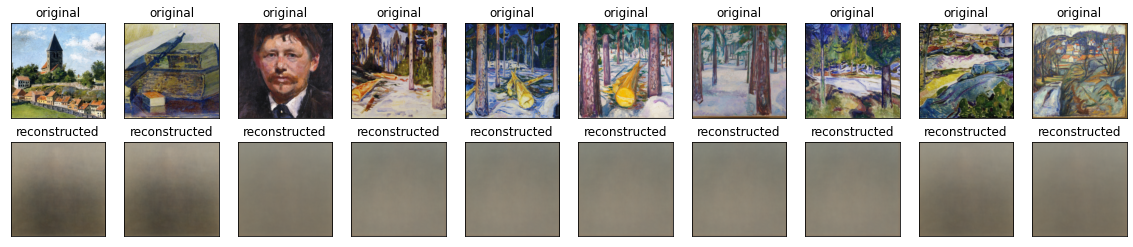

In [31]:
n = 10
plt.figure(figsize=(20, 4))
# images, labels = next(iter(test_loader))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  # plt.imshow(test_data.images[i])
  # plt.imshow(images[i].numpy().transpose((1, 2, 0)))
  plt.imshow(ori_imgs_te[0][i].reshape((3,256,256)).transpose((1, 2, 0)))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_imgs_te[0][i].reshape((3,256,256)).transpose((1, 2, 0)))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

3.1 Image denoising

/var/folders/_8/wgwrcgx12rl79q25snrc8l140000gn/T/ipykernel_3139/3965081409.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_noisy = torch.tensor(image) + noise_factor * torch.randn(image.shape)


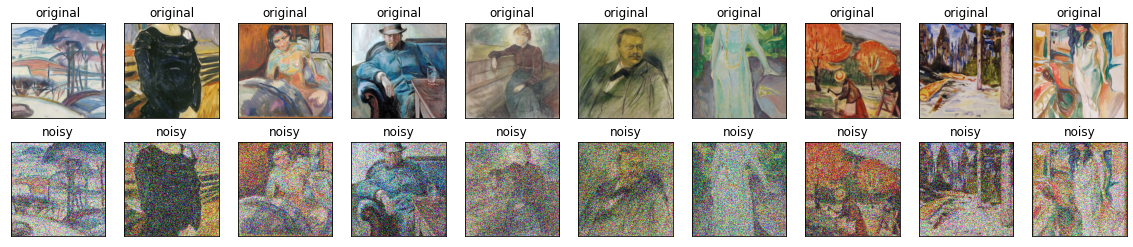

In [33]:
# add noise
def add_noise(image, noise_factor):
    image_noisy = torch.tensor(image) + noise_factor * torch.randn(image.shape)
    image_noisy = torch.clamp(image_noisy,min=0., max=1.)
    return image_noisy

n = 10
plt.figure(figsize=(20, 4))
images, labels = next(iter(train_loader))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images[i].numpy().transpose((1, 2, 0)))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(add_noise(images[i], 0.5).numpy().transpose((1, 2, 0)))
  plt.title("noisy")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [34]:
# latent_dim = 64

class Autoencoder_Denoise(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # self.latent_dim = latent_dim
        # encoder (1 layer); Input=3*256*256
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
            )
        # decoder (1 layer)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1)
            )

    def forward(self, input_features):
        encoded = self.encoder(input_features)
        decoded = self.decoder(encoded)
        return decoded
    
# load model to the specified device, either gpu or cpu
autoencoder_denoise = Autoencoder_Denoise().to(device)
optimizer_denoise = torch.optim.Adam(autoencoder_denoise.parameters(), lr=1e-3)
criterion_denoise = nn.MSELoss()

# Train model
def train_AE_denoise(num_epochs,model,optimizer,criterion,train_loader,valid_loader,noise_factor):
    # for epoch in tqdm(range(epochs)):
    for epoch in range(num_epochs):
        loss_tr = 0
        loss_val = 0
        # training loop
        for batch_features, _ in train_loader:
            # print("######",batch_features.shape)
            # load it to active device
            batch_features = batch_features.to(device)
            batch_features_noisy = add_noise(batch_features, noise_factor=noise_factor).to(device)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            # compute reconstructions
            outputs = model(batch_features_noisy)
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            # compute accumulated gradients
            train_loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # add the mini-batch training loss to epoch loss
            loss_tr += train_loss.item()
        # compute the epoch training loss
        loss_tr = loss_tr / len(train_loader)

        # valid loop
        with torch.no_grad():
            model.eval()
            for batch_features, _ in valid_loader: 
                batch_features = batch_features.to(device)
                batch_features_noisy = add_noise(batch_features, noise_factor=noise_factor).to(device)
                denoised = model(batch_features_noisy)
                valid_loss = criterion(denoised, batch_features)
                loss_val += valid_loss.item()
            loss_val = loss_val / len(train_loader)

        # display the epoch loss
        print("epoch : {}/{},  traing loss = {:.6f}, valid loss = {:.6f}".format(epoch + 1, num_epochs, loss_tr, loss_val))

noise_factor = 0.5
train_AE_denoise(num_epochs=10,model=autoencoder_denoise,optimizer=optimizer_denoise,\
    criterion=criterion_denoise,train_loader=train_loader, valid_loader=valid_loader, noise_factor=noise_factor)

/var/folders/_8/wgwrcgx12rl79q25snrc8l140000gn/T/ipykernel_3139/3965081409.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_noisy = torch.tensor(image) + noise_factor * torch.randn(image.shape)


epoch : 1/10,  traing loss = 0.207391, valid loss = 0.014426
epoch : 2/10,  traing loss = 0.018037, valid loss = 0.000959
epoch : 3/10,  traing loss = 0.007449, valid loss = 0.000863
epoch : 4/10,  traing loss = 0.006964, valid loss = 0.000863
epoch : 5/10,  traing loss = 0.006984, valid loss = 0.000812
epoch : 6/10,  traing loss = 0.006631, valid loss = 0.000762
epoch : 7/10,  traing loss = 0.006400, valid loss = 0.000757
epoch : 8/10,  traing loss = 0.006363, valid loss = 0.000763
epoch : 9/10,  traing loss = 0.006420, valid loss = 0.000743
epoch : 10/10,  traing loss = 0.006298, valid loss = 0.000735


In [35]:
# Summary of the model
print(autoencoder_denoise)

Autoencoder_Denoise(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


3.2 model testing

In [36]:
def test_AE_denoise(model,test_loader,noise_factor):
    loss = 0
    denoised_imgs = []
    noisy_imgs = []
    with torch.no_grad():
        model.eval()
        for batch_features,_ in test_loader:
            batch_features = batch_features.to(device)
            batch_features_noisy = add_noise(batch_features, noise_factor=noise_factor).to(device)
            denoised = model(batch_features_noisy)
            test_loss = criterion(denoised, batch_features)
            loss += test_loss.item()
            denoised_imgs.append(denoised.numpy())
            noisy_imgs.append(batch_features_noisy.numpy())
        loss = loss / len(test_loader)
        print("Testing loss = {:.6f}".format(loss))
    return noisy_imgs,denoised_imgs

noisy_imgs_te,denoised_imgs_te = test_AE_denoise(model=autoencoder_denoise,test_loader=test_loader,noise_factor=noise_factor)    

/var/folders/_8/wgwrcgx12rl79q25snrc8l140000gn/T/ipykernel_3139/3965081409.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_noisy = torch.tensor(image) + noise_factor * torch.randn(image.shape)


Testing loss = 0.006197


3.3. test denoised image display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

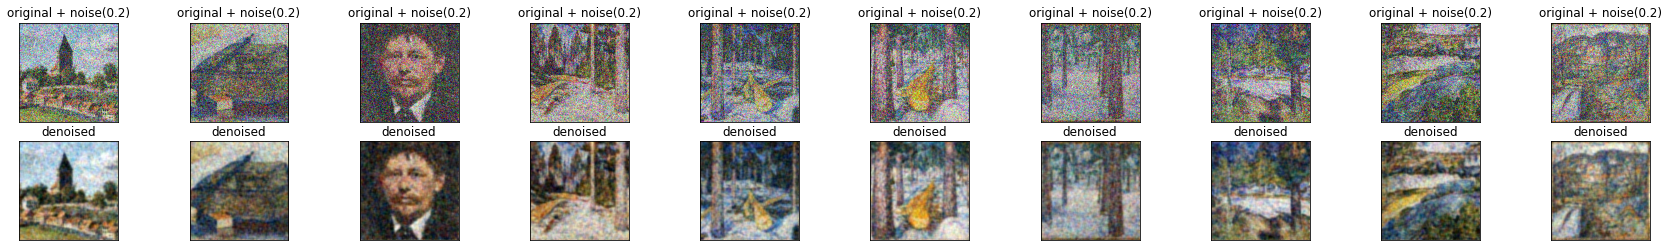

In [37]:
n = 10
plt.figure(figsize=(30, 4))
# images, labels = next(iter(test_loader))
for i in range(n):
  # display original + noise
  ax = plt.subplot(2, n, i + 1)
  # plt.imshow(noisy_imgs_te[0][i].reshape((28,28)))
  plt.imshow(noisy_imgs_te[0][i].reshape((3,256,256)).transpose((1, 2, 0)))
  plt.title("original + noise(0.2)")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display denoised
  ax = plt.subplot(2, n, i + 1 + n)
  # plt.imshow(denoised_imgs_te[0][i].reshape((28,28)))
  plt.imshow(denoised_imgs_te[0][i].reshape((3,256,256)).transpose((1, 2, 0)))
  plt.title("denoised")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()